In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [2]:
# import data
dataset_train = pd.read_csv('downloads/Google_Stock_Price_Train.csv')
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,01/03/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,01/04/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,01/05/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,01/06/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,01/09/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
#keras only takes numpy array
training_set = dataset_train.iloc[:, 1:2].values

In [4]:
training_set.shape

(1509, 1)

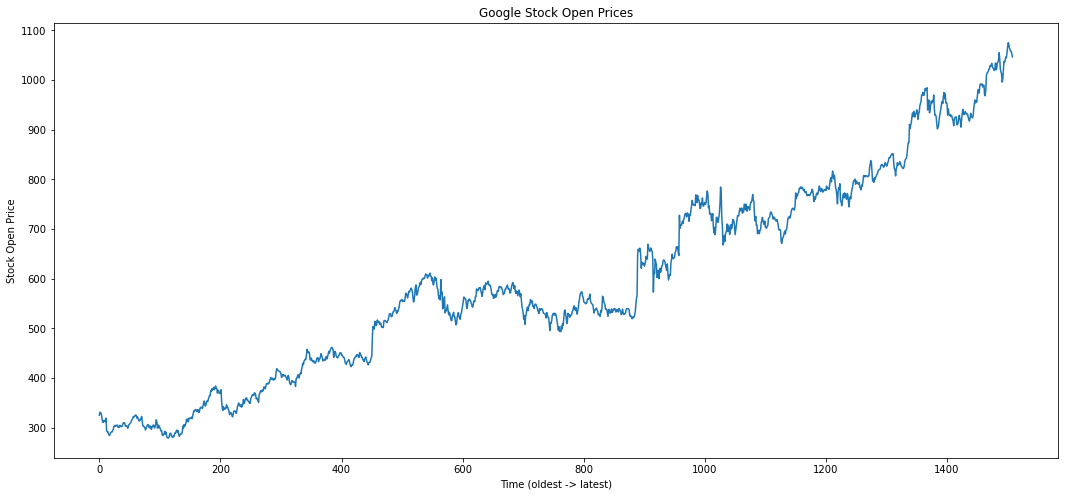

In [5]:
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Open'])
plt.title("Google Stock Open Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Open Price")
plt.show()

In [6]:
# feature scaling
sc = MinMaxScaler(feature_range = (0, 1))
#fit: get min/max of train data
training_set_scaled = sc.fit_transform(training_set)

In [7]:
## 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
X_train.shape

(1449, 60)

In [9]:
y_train.shape

(1449,)

In [10]:
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))

In [11]:
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

##add output layer
regressor.add(Dense(units = 1))

In [12]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [13]:
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)

Epoch 1/100
46/46 [==============================] - 10s 83ms/step - loss: 0.0254
Epoch 2/100
46/46 [==============================] - 4s 85ms/step - loss: 0.0039
Epoch 3/100
46/46 [==============================] - 4s 90ms/step - loss: 0.0034
Epoch 4/100
46/46 [==============================] - 4s 88ms/step - loss: 0.0033
Epoch 5/100
46/46 [==============================] - 4s 90ms/step - loss: 0.0030
Epoch 6/100
46/46 [==============================] - 4s 92ms/step - loss: 0.0029
Epoch 7/100
46/46 [==============================] - 4s 91ms/step - loss: 0.0031
Epoch 8/100
46/46 [==============================] - 5s 99ms/step - loss: 0.0034
Epoch 9/100
46/46 [==============================] - 4s 93ms/step - loss: 0.0027
Epoch 10/100
46/46 [==============================] - 4s 85ms/step - loss: 0.0031
Epoch 11/100
46/46 [==============================] - 4s 93ms/step - loss: 0.0028
Epoch 12/100
46/46 [==============================] - 6s 128ms/step - loss: 0.0028
Epoch 13/100
46/46 [===

46/46 [==============================] - 7s 148ms/step - loss: 8.9639e-04
Epoch 100/100
46/46 [==============================] - 7s 153ms/step - loss: 9.3904e-04


In [14]:
dataset_test = pd.read_csv('downloads/Google_Stock_Price_Test.csv')

In [15]:
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,02/01/2018,1048.339966,1066.939941,1045.229980,1065.000000,1237600
1,03/01/2018,1064.310059,1086.290039,1063.209961,1082.479980,1430200
2,04/01/2018,1088.000000,1093.569946,1084.001953,1086.400024,1004600
3,05/01/2018,1094.000000,1104.250000,1092.000000,1102.229980,1279100
4,08/01/2018,1102.229980,1111.270020,1101.619995,1106.939941,1047600


In [16]:
#keras only takes numpy array
real_stock_price = dataset_test.iloc[:, 1:2].values
real_stock_price.shape

(125, 1)

In [17]:
#vertical concat use 0, horizontal uses 1
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
##use .values to make numpy array
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

In [18]:
#reshape data to only have 1 col
inputs = inputs.reshape(-1, 1)

#scale input
inputs = sc.transform(inputs)

In [19]:
len(inputs)

185

In [20]:
X_test=[]
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [21]:
X_test.shape

(125, 60, 1)

In [22]:
predicted_stock_price = regressor.predict(X_test)

4/4 [==============================] - 5s 56ms/step


In [23]:
#inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

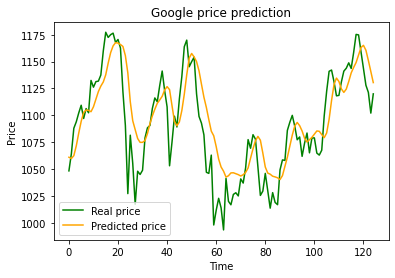

In [24]:
##visualize the prediction and real price
plt.plot(real_stock_price, color = 'green', label = 'Real price')
plt.plot(predicted_stock_price, color = 'orange', label = 'Predicted price')

plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(real_stock_price, predicted_stock_price)
print("MSE:", mse)

MSE: 817.5055026552803


In [26]:
rmse = mean_squared_error(real_stock_price, predicted_stock_price, squared=False)
print("RMSE:", rmse)

RMSE: 28.59205313815852
